In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from src.utils.load_dataframe import load_time_series_60min

In [3]:
# 1. Select the target column and preprocess the data
df = load_time_series_60min()
target_column = 'DE_load_actual_entsoe_transparency'
y = df[target_column].values


In [4]:
# Using only the target column for prediction
X = y

In [5]:
# Ensure no missing values
X = X[~np.isnan(X)]
y = y[~np.isnan(y)]

In [6]:
# 2. Prepare the data for LSTM
# LSTMs need sequence data, so we convert the time series into sliding windows.

scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X.reshape(-1, 1))  # Scale X

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))  # Scale y

In [7]:
# Function to create time windows (sequences)
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [8]:
# Define sequence length
seq_length = 60  # Use 60 previous timestamps to predict the next one

In [9]:
# Create sequences from scaled X and y
X_seq, y_seq = create_sequences(X_scaled, seq_length)
y_seq = y_seq.reshape(-1, 1)


In [10]:
# Reshape X to be compatible with LSTM input
X_seq = np.reshape(X_seq, (X_seq.shape[0], X_seq.shape[1], 1))

In [11]:
# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


In [12]:
# 4. Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

2024-09-13 22:31:02.322709: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-09-13 22:31:02.322724: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2024-09-13 22:31:02.322729: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2024-09-13 22:31:02.322743: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 22:31:02.322752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/alejandrovelazco/work/master-tfm/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


2024-09-13 22:31:03.080998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1259/1259 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.0291 - val_loss: 0.0025
Epoch 2/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 0.0041 - val_loss: 9.6299e-04
Epoch 3/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.0024 - val_loss: 6.4990e-04
Epoch 4/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0016 - val_loss: 6.9319e-04
Epoch 5/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0013 - val_loss: 6.4908e-04
Epoch 6/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.0012 - val_loss: 5.0619e-04
Epoch 7/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0011 - val_loss: 4.6242e-04
Epoch 8/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.0010 - val_loss: 4.5087e-04
Epoch 9/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 9.5494e-04 - val_loss: 4.5571e-04
Epoch 10/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 9.2187e-04 - val_loss: 4.2383e-04
Epoch 11/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 8

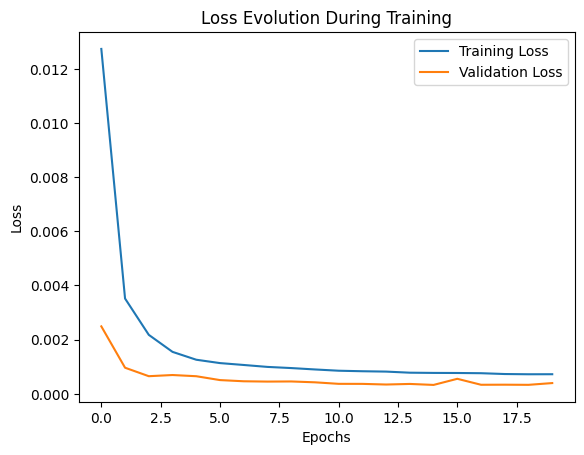

In [15]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# 5. Evaluate the model

# Make predictions with the model
y_pred = model.predict(X_test)


315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [17]:
# Inverse scaling for both predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)


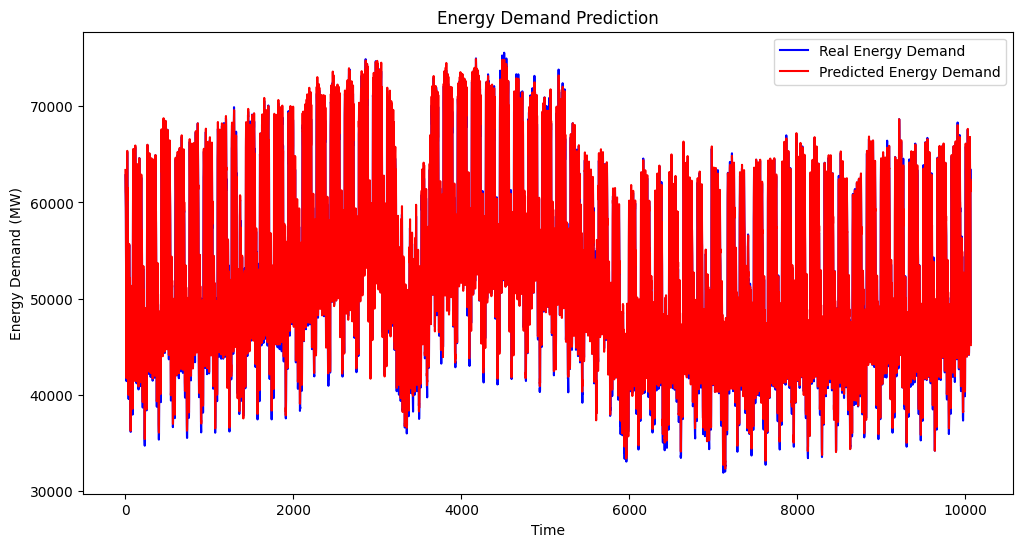

In [18]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Real Energy Demand')
plt.plot(y_pred, color='red', label='Predicted Energy Demand')
plt.title('Energy Demand Prediction')
plt.xlabel('Time')
plt.ylabel('Energy Demand (MW)')
plt.legend()
plt.show()

In [19]:
# 6. Compute performance metrics

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
# R-squared (R²)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared (R2): {r2}')

# Custom Accuracy: Calculate how many predictions fall within a defined tolerance
threshold = 0.05  # 5% tolerance
accurate_predictions = np.abs((y_pred - y_test) / y_test) < threshold
accuracy = np.mean(accurate_predictions) * 100  # Convert to percentage

print(f'Custom Accuracy within {threshold * 100}% tolerance: {accuracy}%')

Mean Squared Error: 846494.0653136148
Mean Absolute Error: 728.1640983887688
Root Mean Squared Error: 920.0511210327471
R-squared (R2): 0.9912556284237464
Custom Accuracy within 5.0% tolerance: 98.59952324195471%


In [20]:
# Calculate residuals
residuals = y_test - y_pred

In [21]:
# Plot actual vs predicted values and residuals
plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

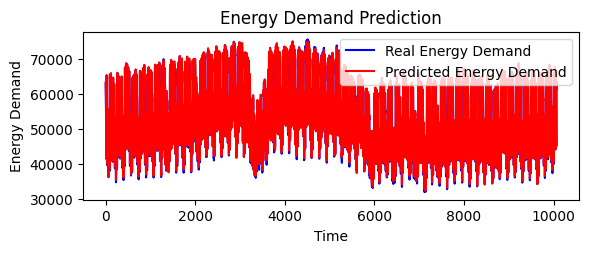

In [22]:
# Plot real vs predicted energy demand
plt.subplot(2, 1, 1)
plt.plot(y_test, color='blue', label='Real Energy Demand')
plt.plot(y_pred, color='red', label='Predicted Energy Demand')
plt.title('Energy Demand Prediction')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.legend()


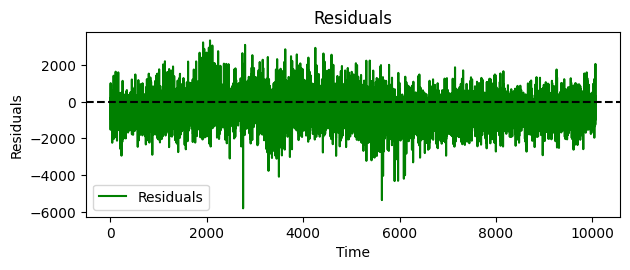

In [23]:
# Plot residuals
plt.subplot(2, 1, 2)
plt.plot(residuals, color='green', label='Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# 8. Use the model to make predictions for 2020
# Ensure that the index is a datetime column
# Index is already 'utc_timestamp' after parsing
df.index = pd.to_datetime(df.index)

In [26]:
df_2020 = df[df.index.year == 2020]  # Filter by the year 2020

In [27]:
# Select the target column for Germany's energy demand
y_2020 = df_2020[target_column].values

In [28]:
# Scale the data
y_2020_scaled = scaler_y.transform(y_2020.reshape(-1, 1))  # Use the same scaler from training


In [29]:
# Create sequences from 2020 data
X_2020_seq, _ = create_sequences(y_2020_scaled, seq_length)

In [30]:
# Reshape X to be compatible with LSTM input
X_2020_seq = np.reshape(X_2020_seq, (X_2020_seq.shape[0], X_2020_seq.shape[1], 1))


In [31]:
# 9. Predict for 2020 and invert scaling
predictions_2020_scaled = model.predict(X_2020_seq)
predictions_2020 = scaler_y.inverse_transform(predictions_2020_scaled)

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [32]:
# Create a DataFrame with predictions and dates
predictions_2020_df = pd.DataFrame({
    'utc_timestamp': df_2020.index[seq_length:],  # Since 'utc_timestamp' is now the index
    'predictions': predictions_2020.flatten()
})

In [33]:
# Aggregate predictions by month
monthly_predictions_2020 = predictions_2020_df.resample('ME', on='utc_timestamp').sum()


/var/folders/54/ddzf5nq5133324qrz2cb0_gc0000gn/T/ipykernel_6942/488780737.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_predictions_2020 = predictions_2020_df.resample('M', on='utc_timestamp').sum()


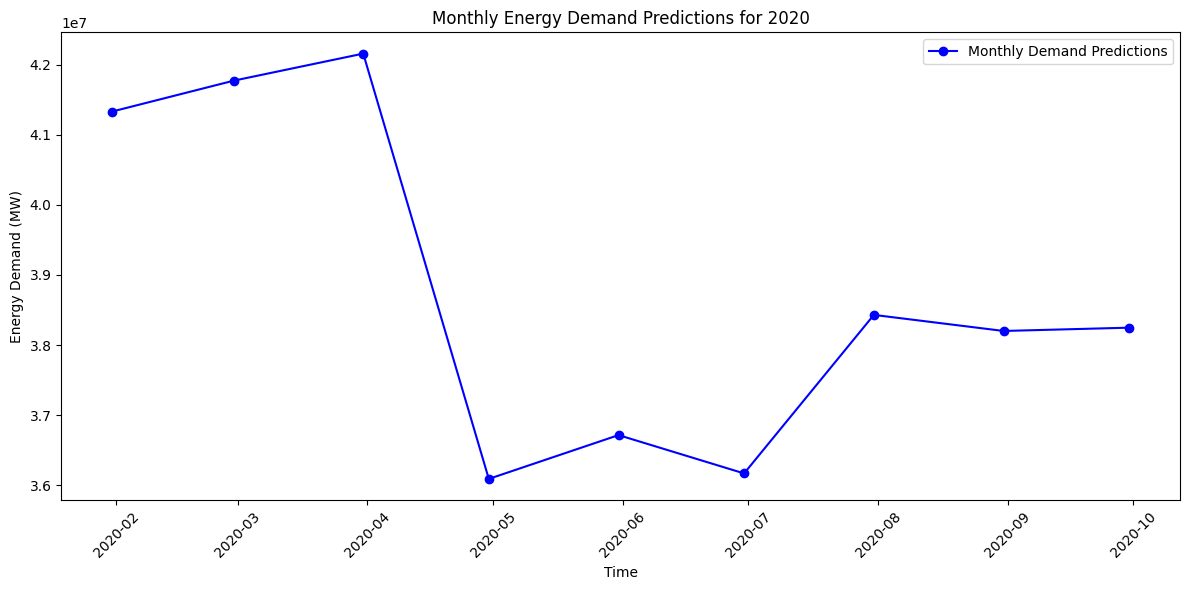

In [43]:
# 10. Plot monthly predictions
plt.figure(figsize=(12, 6))
plt.plot(monthly_predictions_2020.index, monthly_predictions_2020['predictions'], color='blue', marker='o', label='Monthly Demand Predictions')
plt.title('Monthly Energy Demand Predictions for 2020')
plt.xlabel('Time')
plt.ylabel('Energy Demand (MW)')
plt.legend()
# Format x-axis to show months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()
plt.show()

In [37]:
# 11. Compare monthly predictions with actual demand

# Real demand for 2020
real_demand_2020 = df_2020[target_column].values[seq_length:]

In [38]:
# Create a DataFrame for real monthly demand
real_demand_2020_df = pd.DataFrame({
    'utc_timestamp': df_2020.index[seq_length:],  # Since 'utc_timestamp' is now the index
    'real_demand': real_demand_2020
})

In [39]:
# Aggregate real demand by month
real_monthly_demand_2020 = real_demand_2020_df.resample('ME', on='utc_timestamp').sum()


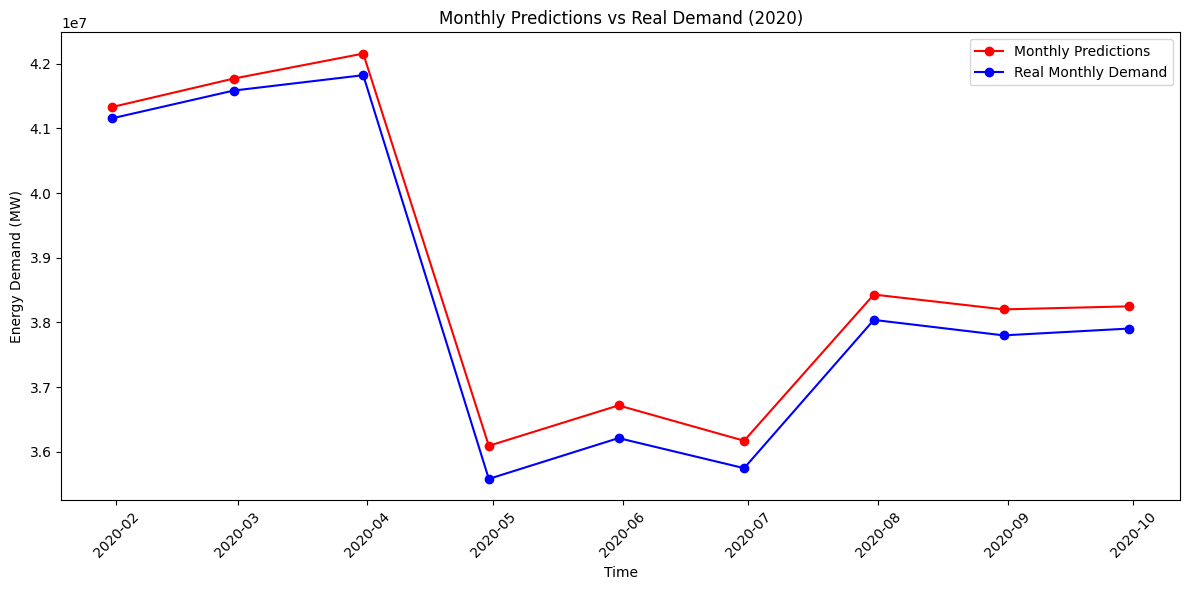

In [42]:
# Plot predictions vs real demand
plt.figure(figsize=(12, 6))
plt.plot(monthly_predictions_2020.index, monthly_predictions_2020['predictions'], color='red', marker='o', label='Monthly Predictions')
plt.plot(real_monthly_demand_2020.index, real_monthly_demand_2020['real_demand'], color='blue', marker='o', label='Real Monthly Demand')
plt.title('Monthly Predictions vs Real Demand (2020)')
plt.xlabel('Time')
plt.ylabel('Energy Demand (MW)')
plt.legend()
# Format x-axis to show months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()